# Test Data Generation

## Prerequisites:
--------------------

It is assumed all customers (at least 1 is needed to run this) **have**,

### Pro Subscription Status:
* completed the PropertyMe setup,
  * a dummy pro-subscription status is needed to complete this (and thus a dummy Visa), see [this link from Stripe](https://stripe.com/docs/testing#charges-api) on test cards.
* `<add key="IsBypassingCheckStripeSubScription" value="true"/>` update this value in pM.ApiHost\Web.config as well as PropertyMe.ManagerApp.BusWorker\App.config

### Various "Dummy Account" Values:
* a dummy bank account attached (this is constant across the folios generated per customer),
* a dummy address in JSON and single-line-text formats (this is fine as a constant per customer),

### An Overriden Property Limit:
* override the max-property limit of 200. **PROPERTIES > 200 WILL NOT BE CREATED AND DATA MAY NOT INSERT AS EXPECTED IF YOU SKIP THIS!**
* Having already set `IsBypassingCheckStripeSubScription`, continue with this script and set the PROPERTY_LIMIT constant and proceed with the pre-setup sql execution to apply an UPDATE to the Subscription table.

In [1]:
import json
from collections import Counter
from multiprocessing import Process
from threading import Thread

import numpy as np
import pandas as pd
import requests as r
from tqdm.auto import tqdm

from Auth import UserSession, UserSessionsHandler
from CommonLib import NotebookHelper, Stats, ConsoleHelpers
from CommonLib.Time import FunctionExecutionTimer
from Config import (ConfigureCsvFilename, ConfigureDbTableName,
                    ConfigureMySqlConnectionString, ConfigurePropertyMeBaseUrl)
from Database import *
from DataGeneration import ContactBuilder, DataGen, LotBuilder, TenancyBuilder

## Workflow:
--------------------
1. Set Constants;
   * This includes default values used herein.
2. Retrieve Filtered LoadTesting Users;
   * These should already exist and be retrievable via SQL or be cached in a local csv.
   * Authentication credentials must be included with each user.
3. Authenticate LoadTesting Users;
   * Utilise the pre-generated credential(s) here.
   * Mass authentication is triggered once all user sessions are constructed by the handler.
4. Update LoadTesting Users' Subscriptions (Prop-Limit Fix);
   * Apply an UPDATE to all User's - unlocking their propertylimits.
5. Create and Insert Tenancy Data for Load Testing Customers;
   * Create and utilise a 'meta' builder to step through all required entities. This enforces FK linkages.

## 1. Testing Data Constants
--------------------

Here we define Constants for the Data Generation. This could easily be adapted to a csv or SQL reader to read potential customer load testers that are preconfigured.

~~A Caveat at the moment is that CustomerID is a constant. Future changes should rectify this and make it dynamic for *wide testing*, as apposed to this single-customer "deep" test.~~

The `CloneArrearsAutomationTest` script/notebook duplicates the data generated by this script! Consider this as a precursor.

In [2]:
dateOfTesting = "2021-10-27"
env_locale = "LOCALHOST"

class FileConfig:
    def __init__(self, defaultfn: str):
        self.fn = None
        self.defaultfn = defaultfn
        
    def __repr__(self):
        return f"File config for: {self.fn}"

# file handling
testuserFileNamesConf = {
    "DEEP USER": FileConfig(f"{dateOfTesting} deepuser-data {env_locale}"), 
    "WIDE USER": FileConfig(f"{dateOfTesting} wideuser-data {env_locale}")
}

testautoFileNamesConf = {
    "DEEP AUTOMATIONS": FileConfig(f"{dateOfTesting} deepuser-automations {env_locale}"), 
    "WIDE AUTOMATIONS": FileConfig(f"{dateOfTesting} wideuser-automations {env_locale}")
}

rawDataFileNamesConf = {
    "DEEP RAW DATA": FileConfig(f"{dateOfTesting} deep-raw-data {env_locale}"), 
    "WIDE RAW DATA": FileConfig(f"{dateOfTesting} wide-raw-data {env_locale}")
}

fileConfs = [
    testuserFileNamesConf, 
    testautoFileNamesConf, 
    rawDataFileNamesConf
]

In [3]:
PROPERTY_LIMIT = 5000
divider = "********************************************************************************"

dbString = None
customers = pd.DataFrame()

baseUrl = ConfigurePropertyMeBaseUrl()

# This is always called. 
# We do not re-read customer data from the database again, as this should have 
# been completed in prev testing setup-and-run steps.

print("== FILE CONFIGURATION ==")
print("""
    The csv will require columns titled: CustomerId, Username, Pw, MessageTemplateId
    If these values are missing, then subsequent operations may fail unexpectedly."""
)

# Conf the file save locations
for fn_grp in fileConfs:
    for config_key in fn_grp:
        if not fn_grp[config_key].fn:
            print(f"\tConfiguring {config_key}")
            fn_grp[config_key].fn = ConfigureCsvFilename(fn_grp[config_key].defaultfn)
        else:
            print(f"\tExisting config detected. Skipping reconfig for {config_key}")


== CONFIGURING URL ==

Shortcut options:
- Entering no value will use default URL "http://localhost:8080"
- Enter "dev1" to use "https://app-dev1.sandbox.propertyme.com"
- Enter "dev2" to use "https://app-dev2.sandbox.propertyme.com"
- Enter "master" to use "https://master-app.propertyme.com"
- Enter "uat" to use "https://uat-app.propertyme.com"
- Enter "stage" to use "https://stage.propertyme.com"



	Enter URL:  


	Selected URL: http://localhost:8080



Do you want to proceed with this configuration? (Enter 'n' to retry, else type any other character to continue):  


== FILE CONFIGURATION ==

    The csv will require columns titled: CustomerId, Username, Pw, MessageTemplateId
    If these values are missing, then subsequent operations may fail unexpectedly.
	Configuring DEEP USER


Enter the csv filename (exclude the .csv extension suffix. Enter no value to default to "2021-10-27 deepuser-data LOCALHOST"):  



The full filename will be "2021-10-27 deepuser-data LOCALHOST.csv"
	Configuring WIDE USER


Enter the csv filename (exclude the .csv extension suffix. Enter no value to default to "2021-10-27 wideuser-data LOCALHOST"):  



The full filename will be "2021-10-27 wideuser-data LOCALHOST.csv"
	Configuring DEEP AUTOMATIONS


Enter the csv filename (exclude the .csv extension suffix. Enter no value to default to "2021-10-27 deepuser-automations LOCALHOST"):  



The full filename will be "2021-10-27 deepuser-automations LOCALHOST.csv"
	Configuring WIDE AUTOMATIONS


Enter the csv filename (exclude the .csv extension suffix. Enter no value to default to "2021-10-27 wideuser-automations LOCALHOST"):  



The full filename will be "2021-10-27 wideuser-automations LOCALHOST.csv"
	Configuring DEEP RAW DATA


Enter the csv filename (exclude the .csv extension suffix. Enter no value to default to "2021-10-27 deep-raw-data LOCALHOST"):  



The full filename will be "2021-10-27 deep-raw-data LOCALHOST.csv"
	Configuring WIDE RAW DATA


Enter the csv filename (exclude the .csv extension suffix. Enter no value to default to "2021-10-27 wide-raw-data LOCALHOST"):  



The full filename will be "2021-10-27 wide-raw-data LOCALHOST.csv"


## 2. Read (Filtered & Validated) Load Testing Customers
--------------------

In [4]:
# Retrieve the load testing customer data
print(divider)
print('\nLOADING CUSTOMER DATA:')

print('\nCustomer rows from file (customerId, username, messageTemplateId, memberId, managerId) (Password not shown):')
customers = pd.read_csv(testuserFileNamesConf["DEEP USER"].fn)
NotebookHelper.Output(customers.drop(["Pw"], axis=1).head())
ConsoleHelpers.PreventImmediateConsoleClose("**CHECK CUSTOMER DATA IS AS EXEPCTED**")

print(divider)

********************************************************************************

LOADING CUSTOMER DATA:

Customer rows from file (customerId, username, messageTemplateId, memberId, managerId) (Password not shown):


,Unnamed: 0,CustomerId,Username,MessageTemplateId,MemberId,ManagerId
0,0,adce02d0-2dc9-47f0-af5c-949eb6602db2,deeptest_aaloadtestinguser@propertyme.com,70c51073-a0e1-11e8-b126-a08cfde6627b,adce02d0-2dea-4b1b-8e6e-300d9686f3ca,adce02d0-2dea-4b1b-8e6e-300d9686f3ca




**CHECK CUSTOMER DATA IS AS EXEPCTED**


Hit "Enter" with no value to close console. 


********************************************************************************


## 3. Authenticate Load Testing Customers
--------------------

In [5]:
# Configure the load testing 'customer' authentication sessions.
print(divider)
print('\nAUTHENTICATING AND OBTAINING SESSION DATA FOR EACH CUSTOMER:')

def MakeSession(s: pd.Series, handler: UserSessionsHandler):
    """Functional approach is a neat way to easily auth users in a dataframe."""
    return handler.AddUserSession(s.Username, s.Pw)

pmeHandler = UserSessionsHandler(baseUrl)
customers.apply(lambda c: MakeSession(c, pmeHandler), axis=1)
pmeHandler.AuthenticateSessions()

print('\n\n**CHECK CUSTOMER DATA IS ALL EXPECTED**')
print(f"{len(pmeHandler.Sessions)} sessions were created.")
print(f"Session summary:\t{pmeHandler.Sessions[:5]}")
endSectionMessage = "To re-execute the script and start again, close the program via the window [x] button."
ConsoleHelpers.PreventImmediateConsoleClose(endSectionMessage)

print(divider)

********************************************************************************

AUTHENTICATING AND OBTAINING SESSION DATA FOR EACH CUSTOMER:
Authenticating for deeptest_aaloadtestinguser@propertyme.com


**CHECK CUSTOMER DATA IS ALL EXPECTED**
1 sessions were created.
Session summary:	[Login: deeptest_aaloadtestinguser@propertyme.com | IsAuthenticated: True]


To re-execute the script and start again, close the program via the window [x] button.


Hit "Enter" with no value to close console. 


********************************************************************************



## 5. Create and Insert Tenancy Data for Load Testing Customers
--------------------

### To insert test data for a tenancy,
1. Generate a unique contact and lot (using dummy address) per n records (lot then record);
2. Generate a folio entry for each new contact (using bank account);
3. Given generated folio ID, generate a unique tenancy per folio entry (IDs of folio and tenancy are linked FK / PK - weird I know);


### Controlling the days in arrears per tenant

Days in arrears are calculated with the following code snippet, in our data generation we dont set the `lastEffPaidTo` field. Hence, the second formula is how Days in Arrears will be calculated.

``` C#
var lastEffPaidTo = db.Scalar<RentPaid, DateTime?>(RP => Sql.Max(RP.EffectivePaidTo), 
                                                   RP => RP.TenancyId == item.TenancyId
                                                   && RP.JournalNumber < item.JournalNumber 
                                                   && RP.EffectivePaidTo != null);
if (lastEffPaidTo != null)
    rentPaid.ArrearsDays = (rentPaid.PaidOn - lastEffPaidTo.Value).Days;
else
    rentPaid.ArrearsDays = (rentPaid.PaidOn - tenancy.TenancyStart.AddDays(-1)).Days;
```

*ArrearsDays* = *rentPaid.PaidOn* - *lastEffectivePaidTo* **or** *ArrearsDays* = *rentPaid.PaidOn* - *tenancy.TenancyStart* - *1 day*

### Generator Configuration

Here we utilise the constants set previously and define new `builders` for each entity-type to generate. The resultant generators are returned in a dict keyed by the entity they generate. Given this generator configuration, each entity needs to be produced in relative order. So, we define a meta-generator to 'step' each entity in the correct order. This is important, as this process must be considered atomic to avoid network race conditions. e.g. `POST`'ing a lot and contact to build a tenancy submits the tenancy first and then lot and contact would result in undefined behaviour (typically the tenancy would resolve to empty guids on its contact and lot).

In [6]:
# TODO: Extract me! This is a pretty common concept that should be reusable
def ConfigureDaysInArrears(n, mu=6, sigma=1):
        """ArrearsDays = rentPaid.PaidOn - tenancy.TenancyStart - 1 day
        
        mu, sigma:
            mean and standard deviation, these should be estimated from actual data!
        """
        
        # remove -1 as this cancels our calculation out! It will throw an error!
        # OK I have no idea why -8 throws it...but it does
        filterOutputRange = (-1, -8)
        # negative days in arrears are what matters here
        zdist = Stats.Integer_ZDistribution(mu, sigma, n, negativeDist=True, filterOutputRange=filterOutputRange)
        
        # verify the dataset looks correct
        Stats.GraphHistogramWithOverlay(zdist, "Days in Arrears Test Dataset")
        print("**Assert distribution and dataset are valid**.\nEnter to continue...")
        
        return zdist

def InsertApi(session: UserSession, entity: str, entityName: str) -> str:
    """Insert (POST) an Entity to the PME API at a given baseUrl.
    
    Args
    ----
    
    session: UserSession,
        The authenticated session to POST with.
    
    entity: str,
        The entity name utilised by the API routing. This can be found from the PME controller.
        
    TBD
    baseUrl: str,
        The PME API base address to build the endpoint URL from. e.g.,
        
        "local": "http://localhost:8080",
        "dev1": "https://app-dev1.sandbox.propertyme.com",
        "stage": "https://stage.propertyme.com",
        
        See ConfigurePropertyMeUrl for more examples.
        
    Returns
    -------
    
    res: Json,
        A json result from the endpoint.
    """
    
    global baseUrl
    
    # UserSession should have configured credentials, incl. cookies and the default headers
    apiEndpoint = f"{baseUrl}/api/entity/{entityName}?format=json"
    headers = {"content-type": "application/json"}
    res = session.Current.post(apiEndpoint, data=entity, headers=headers)
    
    if (res.status_code == 500):
        return None
    elif res.text is not None:
        return json.loads(res.text)
    else:
        return ''

In [7]:
# TODO: Extract me! This is a pretty common concept that should be reusable
class PropertyMetaBuilder:
    def __init__(self,
                 customerId: str, 
                 managerId: str,
                 daysInArrears: list[int], 
                 session: UserSession,
                 n: int,
                 numbatches=1):
        
        self._customerID = customerId
        self._managerID = managerId
        self._tenancyIDs = list()
        self._session = session
        self._zdist = daysInArrears
        
        # num iters
        self._n = n
        # batch config
        self._numBatches = numBatches
        self._batchedGenerators = list()
        
        if self._n % self._numBatches != 0:
            raise ValueError("Number of insertions and batch should be evenly divisible!.")
        
        self._k = self._n // self._numBatches
        
        # configure the generators for dependent entities
        # each batch needs new generators
        for i in range(numBatches):
            self._batchedGenerators.append(self._SetupGenerators(i))
    
    def _SetupGenerators(self, i:int) -> dict:
        # set-up the relavent builders
        lBuilder = LotBuilder(self._customerID, self._managerID)
        cBuilder = ContactBuilder(self._customerID)
        tBuilder = TenancyBuilder(self._customerID)
        
        gens = dict()
        
        # set-up the relavent generators
        gens["lotGen"] = DataGen(builder=lBuilder, start=i*self._k)
        gens["contactGen"] = DataGen(builder=cBuilder, start=i*self._k)
        gens["tenancyGen"] = DataGen(builder=tBuilder, start=i*self._k)
        
        return gens
        
    def Step(self, contactGen, lotGen, tenancyGen):
        
        # Contact and Lot are base entities. Generate these first
        contact = InsertApi(self._session, contactGen.next(), "contacts")
        
        if contact is None:
            print("SKIPPING | Duplicate Contact entity")
            return
        
        contactID = contact["ContactId"]
        
        lot = InsertApi(self._session, lotGen.next(), "lots")
        
        if lot is None:
            print("SKIPPING | Duplicate Lot entity")
            return
        
        lotID = lot["LotId"]
        
        # Build the tenancy using it's dependencies
        unsavedTenancy = tenancyGen.next(lotID=lotID, contactID=contactID, daysInArrears=self._zdist.pop())
        tenancy = InsertApi(self._session, unsavedTenancy, "tenancies")
        
        if tenancy is None:
            print("SKIPPING | Duplicate Tenancy entity")
            return
        
        
        # If any insertion errors occur, print the entity return (incl. StackTrace)
        if not contact['IsSuccessful']:
            print(contact)
            
        if not lot['IsSuccessful']:
            print(lot)
            
        if not tenancy['IsSuccessful']:
            print(tenancy)
        
        self._tenancyIDs.append(tenancy["TenancyId"])
    
    def Stepper(self, i):
        for k in tqdm(range(self._k)):
            self.Step(**self._batchedGenerators[i])
    
    @property
    def TenancyIDs(self):
        return self._tenancyIDs
    
    @property
    def UnsuccessfulGenerations(self):
        # Simpler than including a counter manually when the entity 
        # POST returns empty guids.
        return Counter(self._tenancyIDs)["00000000-0000-0000-0000-000000000000"]
    
    @FunctionExecutionTimer()
    def RunBuilder(self):
        threads = list()
        print("Ready to run test data insertion, this will take awhile.")
        for i in range(self._numBatches):
            # if Step finds an existing ID, it returns we continue
            threads.append(Thread(target=self.Stepper, args=[i]))
        
        for t in threads:
            t.start()
        
        for t in threads:
            t.join()
        
        print(f"{len(self.TenancyIDs)} where created.")
        print(f"{self.UnsuccessfulGenerations} failed!\n")

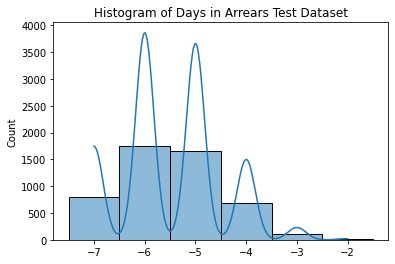

**Assert distribution and dataset are valid**.
Enter to continue...
Ready to run test data insertion, this will take awhile.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

5000 where created.
0 failed!

##########################################################
RunBuilder timed execution summary:
	ran for 820.0055 seconds.
	Started at 2021-10-28 12:37:09.318512 and ended at 2021-10-28 12:50:49.324314.
##########################################################


Complete! Please review the logs to ensure the insertion was as intended. Hit "Enter" immediately to close console.


Hit "Enter" with no value to close console. 


In [8]:
   
customer = customers.iloc[0]
numBatches = 5

PropertyMetaBuilder(
    customerId=customer.name,
    daysInArrears=ConfigureDaysInArrears(PROPERTY_LIMIT),
    managerId=customer.ManagerId, 
    session=pmeHandler.Sessions[0],
    n=PROPERTY_LIMIT,
    numbatches=numBatches
).RunBuilder()

ConsoleHelpers.PreventImmediateConsoleClose('Complete! Please review the logs to ensure the insertion was as intended. Hit "Enter" immediately to close console.')